## Results generation for Figure 4 only
Needed a separate notebook to avoid re-using TF variables when using the
always-on dropout model

In [1]:
import pickle
import tensorflow as tf
from nilearn import plotting, image
from nilearn.input_data import NiftiLabelsMasker
import numpy as np
import matplotlib.pyplot as plt
import load_data
from models import masked_loss
from sklearn import metrics
import pandas as pd
import seaborn as sns
from funcs import *
%matplotlib inline

In [3]:
# Define base directories

project_dir = '/home/nluciw/home/projects/cbfnet/'
data_dir = project_dir + 'data/'

In [4]:
# Point to outputs of training and the files in the test set

output_dir = project_dir + 'output_dir/'
test_files = data_dir + 'study_datasets/test/'+'ge_test.txt'

In [6]:
# Get filenames, GM masks, and create X y dataset with removed PLDs. 

# Use only the non-curriculum trained model
num_removed = range(1)

X_files, y_files = load_data.organize_filenames(test_files)

X_files = [file for file in X_files if 'asl.nii' in file]
y_files = [y_files[i] for i in range(0,len(y_files),4)]
ids = [name.split('/')[-2] for name in X_files]
masks = [data_dir + 'study_datasets/cbfnet_data/masks/sub-{}_T1w_brain_pve_1_flirt.nii.gz'.format(id) for id in ids]
datasets = [load_data.get_dataset(X_files, y_files, batch_size=1, 
                                moments=data_dir+'study_datasets/cbfnet_data/moments.txt', mask_num=i, shuffle=False)\
            for i in num_removed]

segs = [f[:-20]+'_T1w_brain_seg_flirt.nii.gz' for f in X_files]
mni_atlases = [f[:-20]+'_MNI-atlas.nii.gz' for f in X_files]

### Get models and model estimates

In [8]:
# Define the always-on dropout layer

class MonteCarloDropout(tf.keras.layers.Dropout):

        def __init__(self, rate=0.5, **kwargs):
            super(MonteCarloDropout, self).__init__(rate)
            self.rate = rate

        def call(self, inputs):
            return super().call(inputs, training=True)

In [13]:
# Get trained model with always-on dropout

mc_models = []
histories = []
mask_nums = range(1)
for j in mask_nums:
        with open(output_dir+'ge_model_mask{0}.json'.format(j)) as json_file:
            json_config = json_file.read()
        mc_model = tf.keras.models.model_from_json(json_config, custom_objects={'MonteCarloDropout':MonteCarloDropout})
        mc_model.load_weights(output_dir+'ge_weights_mask{0}.h5'.format(j))
        mc_models.append(mc_model)
        with open(output_dir+'ge_history_mask{0}.json'.format(j), 'rb') as json_file:
            histories.append(pickle.load(json_file))

In [14]:
# Get model for point estimates

model_dir = project_dir + 'models/'
models = []
histories = []
mask_nums = range(1)
for j in mask_nums:
        with open(model_dir+'ge_model_mask{0}.json'.format(j)) as json_file:
            json_config = json_file.read()
        model = tf.keras.models.model_from_json(json_config)
        model.load_weights(model_dir+'ge_weights_mask{0}.h5'.format(j))
        models.append(model)
        with open(model_dir+'ge_history_mask{0}.json'.format(j), 'rb') as json_file:
            histories.append(pickle.load(json_file))

In [19]:
ground_truth = [i[1].numpy() for i in datasets[0].take(predictions[0][0].shape[0])]

In [15]:
# Make 500 Monte Carlo dropout estimates

mc_predictions = []
for i in range(500):
    temp_preds = mc_model.predict(datasets[0])
    mc_predictions.append(temp_preds)

In [17]:
predictions = []
for model in models:
    rem_preds = [model.predict(dataset) for dataset in datasets]
    predictions.append(rem_preds)

In [16]:
mc_predictions = np.array(mc_predictions)

#### Calculate uncertainty heuristics

In [18]:
cbf_std = np.std(mc_predictions[...,0], axis=0)
cbf_cov  = np.nan_to_num(cbf_std / predictions[0][0][...,0])
cbf_cov[cbf_cov>100] = 100

att_std = np.std(mc_predictions[...,1], axis=0)
att_cov  = np.nan_to_num(cbf_std / predictions[0][0][...,1])
att_cov[att_cov>100] = 100


/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


### Get regional estimates for the uncertainty values

In [24]:
# Need to overload the function from funcs.py to play nicely
# with the shape of the data in this analysis.

def get_atlas_values(gt_org, pred_org, seg, param='cbf', scaling=1., avg=False):

    def get_metric(y_true, y_pred, mask, param='cbf', metric='mae', scaling=1., tiss_type='GM'):
        ''' y_true: numpy array of ground truth image
        y_pred: numpy array of network prediction/estimate
        mask: str of path to mask file'''
    
        seg_np = image.get_data(mask)
        params = {'cbf':0, 'att':1}
        tissues = {'Frontal': 3,
               "Parietal": 6,
               'Occipital': 5,
               'Subcortical': 1,
               'Temporal': 8}
    
        mask_np = np.repeat(seg_np[...,None], 2, axis=-1)

        params = {'cbf':0, 'att':1}
    
        mask_np[...,params[param]] = 0

        true = y_true[0][mask_np==tissues[tiss_type]] * scaling
        pred = y_pred[seg_np==tissues[tiss_type]] * scaling
    
        if metric =='mae':
            value = metrics.mean_absolute_error(true, pred)
        elif metric == 'ssim':
            t = tf.convert_to_tensor(y_true[0][...,params[param]], dtype=tf.float32)
            p = tf.convert_to_tensor(y_pred[...,params[param]], dtype=tf.float32)

            value = tf.image.ssim(t,p,max_val=2.5, filter_size=11, filter_sigma=1.5).numpy()
        
        return value

    seg_np = image.get_data(seg)
    seg_np[(seg==1) | (seg==4) | (seg==7) | (seg==9)] = 1              
                   
    params = {'cbf':0, 'att':1}
    tissues = {'3': 'Frontal',
               '6': "Parietal",
               '5': 'Occipital',
               '8': 'Temporal',
               '1': 'Subcortical'}
        
    gt = gt_org[...,params[param]] * scaling
    pred = pred_org * scaling
        
    seg_df = []
    for i in tissues.keys():
        if avg:
            gt_temp = gt[seg_np==int(i)].mean()
            pred_temp = pred[seg_np==int(i)].mean()
            diff_temp = get_metric(gt_org[np.newaxis,...], pred_org, seg, param=param, 
                                   metric='mae', scaling=scaling, tiss_type=tissues[str(i)])

            length = 1
        else:
            gt_temp = gt[seg_np==i]
            pred_temp = pred[seg_np==i]
            length = len(gt_temp)
            
        df = pd.DataFrame({'ID': seg.split('/')[-1][4:8],
                              'gt': gt_temp, 
                              'pred': pred_temp,
                              'diff': diff_temp,
                              'Tissue type': [tissues[str(i)],]*length,
                              'param': [params[param],]*length})

        seg_df.append(df)
        
    return pd.concat(seg_df)

In [25]:
# Get the regional values for both heuristics

seg_cbf_cov = [get_atlas_values(ground_truth[i][0], cbf_cov[i], mni_atlases[i], 
                                 scaling=92., avg=True) for i in range(len(mni_atlases))]
seg_att_cov = [get_atlas_values(ground_truth[i][0], att_cov[i], mni_atlases[i], 
                                 scaling=1.36, param='att', avg=True) for i in range(len(mni_atlases))]

seg_cbf_std = [get_atlas_values(ground_truth[i][0], cbf_std[i], mni_atlases[i], 
                                 scaling=92., avg=True) for i in range(len(mni_atlases))]
seg_att_std = [get_atlas_values(ground_truth[i][0], att_std[i], mni_atlases[i], 
                                 scaling=1.36, param='att', avg=True) for i in range(len(mni_atlases))]

In [38]:
# Convert the lists to a single dataframe

seg_cbfs_cov = pd.concat(seg_cbf_cov)
seg_atts_cov = pd.concat(seg_att_cov)

seg_cbfs_stds = pd.concat(seg_cbf_std)
seg_atts_stds = pd.concat(seg_att_std)

In [27]:
# Get diagnoses associated with IDs

dx_df = pd.DataFrame({'ID': seg_cbfs_cov.ID.unique(), 'DX':['D','D', 'MCI', 'D', 'D', 'MCI', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'CU', 'CU', 'CU', 'CU', 'CU', 'D', 'CU']})

In [29]:
# Get regional point estimates for plotting

tiss_avg_cbf = pd.read_csv('regional_cbf_unet_long-train.csv')
tiss_avg_att = pd.read_csv('regional_att_unet_long-train.csv')

In [30]:
# Add uncertainty values to the dataframe with point estimates

tiss_avg_cbf['cov'] = list(seg_cbfs_cov['pred'])
tiss_avg_cbf['std'] = list(seg_cbfs_stds['pred']*1.0)
tiss_avg_cbf['ID'] = list(seg_cbfs_cov['ID'])

tiss_avg_att['cov'] = list(seg_atts_cov['pred'])
tiss_avg_att['std'] = list(seg_atts_stds['pred']*1.0)
tiss_avg_att['ID'] = list(seg_atts_cov['ID'])

In [31]:
# Add diagnosis info

tiss_avg_cbf = pd.merge(tiss_avg_cbf, dx_df, how='left', on='ID')
tiss_avg_att = pd.merge(tiss_avg_att, dx_df, how='left', on='ID')

In [35]:
tiss_avg_cbf.rename(columns={'Tissue type': 'Region'}, inplace=True)
tiss_avg_att.rename(columns={'Tissue type': 'Region'}, inplace=True)

In [69]:
# Save data to csv to perform linear model in R

tiss_avg_cbf.to_csv('region_cbfs_w-unc.csv')
tiss_avg_att.to_csv('region_atts_w-unc.csv')

## Figure 4, all four panels

In [32]:
sns.set(style='whitegrid')

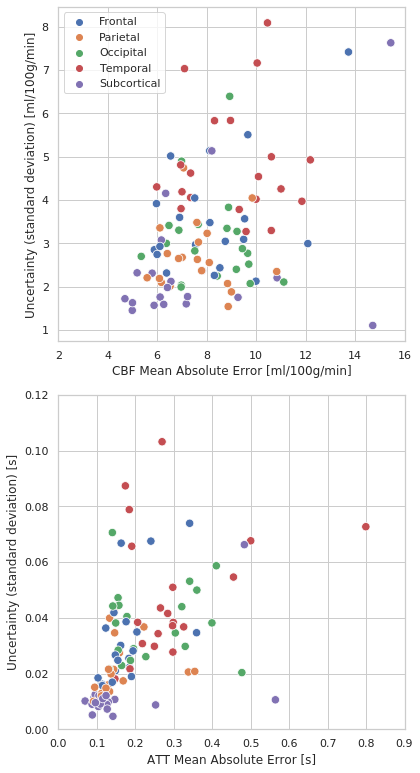

In [36]:
# Plot Figs 4A and 4B

fig, ax = plt.subplots(2,1,figsize=[6,11])

# CBF plot
sns.scatterplot(x='diff', y='std', hue='Region', data=tiss_avg_cbf, alpha=1., ax=ax[0], s=70)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles[1:], labels=['Frontal', 'Parietal', 'Occipital', 'Temporal', 'Subcortical'], 
             loc='upper left')

ax[0].set_xlim([2,16])

ax[0].set_xlabel('CBF Mean Absolute Error [ml/100g/min]')
ax[0].set_ylabel('Uncertainty (standard deviation) [ml/100g/min]')

# ATT plot
sns.scatterplot(x='diff', y='std', hue='Region', data=tiss_avg_att, 
                alpha=1., ax=ax[1], s=70)
ax[1].get_legend().remove()
ax[1].set_ylim([0.,0.12])
ax[1].set_xlim([0.,.9])


ax[1].set_xlabel('ATT Mean Absolute Error [s]')
ax[1].set_ylabel('Uncertainty (standard deviation) [s]')

fig.tight_layout()
#plt.savefig(output_dir + 'uncertainty_scatter_w-region.pdf')

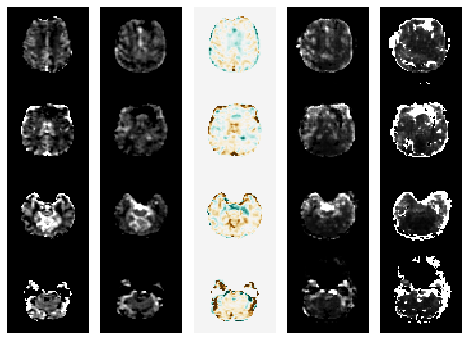

In [37]:
# Plot Figs 4C and 4D. Alter the "individual" variable to get both panels

model_num = 0
individual = 19
num_rem = 0
param = 0

differences = [np.nan_to_num((ground_truth[i][0,...,param] - predictions[0][0][i,...,param])) for i in range(len(ground_truth))]

fig, ax = plt.subplots(4,5, figsize=(8.2,6))
for i in range(4):
    ax[3-i,1].imshow(np.rot90(predictions[0][0][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.522, cmap='gray')
    ax[3-i,1].axis('off')
    ax[3-i,0].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.522, cmap='gray')
    ax[3-i,0].axis('off') 

for i in range(4):
    ax[3-i,2].imshow(np.rot90(predictions[0][0][individual,:,:,4*i,param]-ground_truth[individual][0,:,:,4*i,param], axes=(0,1)), 
                     cmap='BrBG', vmin=-2., vmax=2)
    ax[3-i,2].axis('off')
    
for i in range(4):
    ax[3-i,3].imshow(np.rot90(cbf_std[individual,:,:,4*i], axes=(0,1)), cmap='gray', vmin=0., vmax=0.27175)
    ax[3-i,3].axis('off')
 
for i in range(4):
    ax[3-i,4].imshow(np.rot90(cbf_cov[individual,:,:,4*i], axes=(0,1)), cmap='gray',vmin=0.,vmax=1.0)
    ax[3-i,4].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.1)

#fig.savefig(output_dir + 'ind12_uncertainty_w-diff.pdf')

## Make colourbars for plots

/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


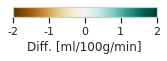

In [119]:
a = np.array([[0,1]])
plt.figure(figsize=(2.5, 0.6))
img = plt.imshow(a, cmap="BrBG")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.7, 0.8, 0.25])
c = plt.colorbar(orientation="horizontal", cax=cax)
c.set_label('Diff. [ml/100g/min]')
_ = c.ax.set_xticklabels(['-2', '-1', '0','1','2'])
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.)
plt.savefig(output_dir + 'diff_cbar.pdf')

/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


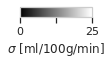

In [28]:
a = np.array([[0,1]])
plt.figure(figsize=(1.25, 0.6))
img = plt.imshow(a, cmap="gray")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.7, 0.8, 0.25])
c = plt.colorbar(orientation="horizontal", cax=cax)
c.set_label(r'$\sigma$ [ml/100g/min]')
_ = c.ax.set_xticklabels(['0', '', '25'])
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.)
plt.savefig(output_dir + 'std_cbar.pdf')

/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


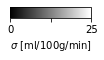

In [4]:
a = np.array([[0,1]])
plt.figure(figsize=(1.5, 0.9))
img = plt.imshow(a, cmap="gray")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.78, 0.75, 0.1667])
c = plt.colorbar(orientation="horizontal", cax=cax)
c.set_label(r'$\sigma$ [ml/100g/min]')
_ = c.ax.set_xticklabels(['0', '', '25'])
plt.tight_layout(pad=2)
plt.savefig(output_dir + 'std_cbar.pdf')
